In [2]:
# If needed, install interactive backend & widgets (uncomment as needed):
# %pip install -q ipympl ipywidgets

# Enable interactive Matplotlib for clicks & live updates:
%matplotlib widget


In [3]:
import io, math, urllib.request
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from transformers import AutoModel

try:
    import ipywidgets as Widget
except Exception:
    Widget = None  # slider is optional

# ---------- Image I/O ----------
def load_image(url_str):
    """Download an image from URL and return a PIL RGB image."""
    with urllib.request.urlopen(url_str) as resp:
        data = resp.read()
    return Image.open(io.BytesIO(data)).convert("RGB")

# ---------- Preprocessing (custom, NO resize) ----------
def pad_to_multiple(pil_img, multiple=16):
    """Pad PIL image on right/bottom so (H,W) are multiples of `multiple`."""
    W, H = pil_img.size
    H_pad = int(math.ceil(H / multiple) * multiple)
    W_pad = int(math.ceil(W / multiple) * multiple)
    if (H_pad, W_pad) == (H, W):
        return pil_img, (0, 0, 0, 0)
    canvas = Image.new("RGB", (W_pad, H_pad), (0, 0, 0))
    canvas.paste(pil_img, (0, 0))
    return canvas, (0, 0, W_pad - W, H_pad - H)

def preprocess_image_no_resize(pil_img):
    """Pad (right/bottom) -> ToTensor -> Normalize (ImageNet stats)."""
    img_padded, pad_box = pad_to_multiple(pil_img, multiple=16)
    transform = transforms.Compose([
        transforms.ToTensor(),  # [0,1], CxHxW
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    pixel_tensor = transform(img_padded).unsqueeze(0)  # (1,3,H,W)
    disp_np = np.array(img_padded, dtype=np.uint8)     # (H,W,3) for display
    return {"pixel_values": pixel_tensor}, disp_np, pad_box

# ---------- Small drawing utilities ----------
def upsample_nearest(arr, H, W, ps):
    """Nearest upsample for 2D or 3D arrays with last-dim channels."""
    if arr.ndim == 2:
        return arr.repeat(ps, 0).repeat(ps, 1)
    elif arr.ndim == 3:
        C = arr.shape[-1]
        return arr.repeat(ps, 0).repeat(ps, 1).reshape(H, W, C)
    raise ValueError("Unsupported ndim for upsample")

def draw_grid(ax, rows, cols, ps):
    for r in range(1, rows):
        ax.axhline(r * ps - 0.5, lw=0.8, alpha=0.6, color="white", zorder=3)
    for c in range(1, cols):
        ax.axvline(c * ps - 0.5, lw=0.8, alpha=0.6, color="white", zorder=3)

def draw_indices(ax, rows, cols, ps):
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            ax.text(c * ps + ps / 2, r * ps + ps / 2, str(idx),
                    ha="center", va="center", fontsize=7,
                    color="white", alpha=0.95, zorder=4)


[two-image] Click to select • arrows move on ACTIVE side • '1'/'2'/'t' switch side


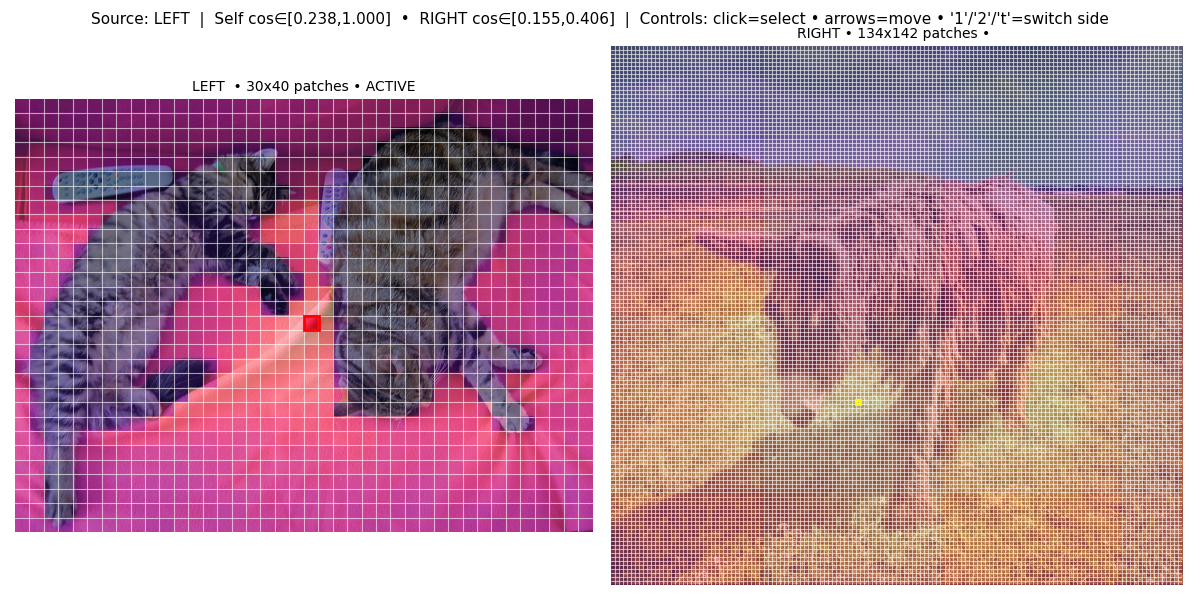

In [6]:
# ---- Available DINOv3 models on Hugging Face ----
# model_id = "facebook/dinov3-vit7b16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vits16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-small-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vitb16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-base-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-tiny-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vitl16-pretrain-sat493m"
# model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vith16plus-pretrain-lvd1689m"
# model_id = "facebook/dinov3-convnext-large-pretrain-lvd1689m"
# model_id = "facebook/dinov3-vit7b16-pretrain-sat493m"

# ---- User config ----
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
model_id = "facebook/dinov3-vits16-pretrain-lvd1689m"  # Choose one from above
show_grid = True
annotate_indices = False
overlay_alpha = 0.55
patch_size_override = None  # set to 16 to force; None = read from model if available 

# ---- Image URLs for one or two image mode ----
url1 = url if 'url' in locals() or 'url' in globals() else "http://images.cocodataset.org/val2017/000000039769.jpg"
url2 = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_left.jpg"

# ---- Model setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_id).to(device)
model.eval()
ps = patch_size_override if patch_size_override is not None else getattr(getattr(model, "config", object()), "patch_size", 16)

def rc_to_idx(r, c, cols): return int(r) * cols + int(c)
def idx_to_rc(i, cols):    return (int(i) // cols, int(i) % cols)

def build_state(pil_img, model, ps, device):
    inputs, disp_np, _ = preprocess_image_no_resize(pil_img)
    pixel_values = inputs["pixel_values"].to(device)
    _, _, H, W = pixel_values.shape
    rows, cols = H // ps, W // ps
    with torch.no_grad():
        out = model(pixel_values=pixel_values)
    hs = out.last_hidden_state.squeeze(0).detach().cpu().numpy()
    n_patches = rows * cols
    patch_embs = hs[-n_patches:, :].reshape(rows, cols, -1)
    X = patch_embs.reshape(-1, patch_embs.shape[-1])
    Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
    return {
        "disp": disp_np, "H": H, "W": W, "rows": rows, "cols": cols, "ps": ps,
        "X": X, "Xn": Xn,
        "ax": None, "overlay_im": None, "sel_rect": None, "best_rect": None
    }

# ---- Load images, fallback to defaults if needed ----
def safe_load_image(url, fallback):
    try:
        return load_image(url)
    except Exception:
        print(f"[warning] Could not load {url}, using fallback {fallback}")
        return load_image(fallback)

if url1 is None or not isinstance(url1, str) or url1.strip() == "":
    url1 = "http://images.cocodataset.org/val2017/000000039769.jpg"
if url2 is not None and (not isinstance(url2, str) or url2.strip() == ""):
    url2 = None

imgL = safe_load_image(url1, "http://images.cocodataset.org/val2017/000000039769.jpg")
imgR = None
if url2:
    imgR = safe_load_image(url2, "http://images.cocodataset.org/val2017/000000039768.jpg")

# ---- Patch similarity visualization ----
if imgR is not None:
    # Two-image mode
    S = [build_state(imgL, model, ps, device), build_state(imgR, model, ps, device)]
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 6))
    axs = [axL, axR]
else:
    # Single-image mode
    S = [build_state(imgL, model, ps, device)]
    fig, axL = plt.subplots(1, 1, figsize=(6, 6))
    axs = [axL]

cmap = plt.get_cmap("magma")

for i, (ax, st) in enumerate(zip(axs, S)):
    st["ax"] = ax
    ax.imshow(st["disp"], zorder=0)
    ax.set_axis_off()
    if show_grid:
        draw_grid(ax, st["rows"], st["cols"], st["ps"])
    if annotate_indices:
        draw_indices(ax, st["rows"], st["cols"], st["ps"])
    init_scalar = 0.5 * np.ones((st["rows"], st["cols"]), dtype=np.float32)
    rgba = cmap(init_scalar)
    rgba_up = upsample_nearest(rgba, st["H"], st["W"], st["ps"])
    st["overlay_im"] = ax.imshow(rgba_up, alpha=0.0, zorder=1)
    st["sel_rect"]  = Rectangle((0, 0), st["ps"], st["ps"], fill=False, lw=2.0, ec="red",    zorder=5)
    st["best_rect"] = Rectangle((0, 0), st["ps"], st["ps"], fill=False, lw=2.0, ec="yellow", zorder=6)
    ax.add_patch(st["sel_rect"])
    ax.add_patch(st["best_rect"])
    st["best_rect"].set_visible(False)

active_side = 0
current_idx = [
    (S[0]["rows"] // 2) * S[0]["cols"] + S[0]["cols"] // 2,
]
if imgR is not None:
    current_idx.append((S[1]["rows"] // 2) * S[1]["cols"] + S[1]["cols"] // 2)

def set_titles(src_i=None, self_stats=None, cross_stats=None):
    if imgR is not None:
        axs[0].set_title(f"LEFT  • {S[0]['rows']}x{S[0]['cols']} patches • {'ACTIVE' if active_side==0 else ''}", fontsize=10)
        axs[1].set_title(f"RIGHT • {S[1]['rows']}x{S[1]['cols']} patches • {'ACTIVE' if active_side==1 else ''}", fontsize=10)
        if src_i is not None and self_stats is not None and cross_stats is not None:
            src_name = "LEFT" if src_i == 0 else "RIGHT"
            tgt_name = "RIGHT" if src_i == 0 else "LEFT"
            fig.suptitle(
                f"Source: {src_name}  |  Self cos∈[{self_stats[0]:.3f},{self_stats[1]:.3f}]  •  "
                f"{tgt_name} cos∈[{cross_stats[0]:.3f},{cross_stats[1]:.3f}]  |  "
                f"Controls: click=select • arrows=move • '1'/'2'/'t'=switch side",
                fontsize=11,
            )
        else:
            fig.suptitle("Controls: click=select • arrows=move • '1'/'2'/'t'=switch side", fontsize=11)
    else:
        axs[0].set_title(f"{S[0]['rows']}x{S[0]['cols']} patches", fontsize=10)
        fig.suptitle("Controls: click=select • arrows=move", fontsize=11)

def clamp_idx(i, st): return int(np.clip(i, 0, st["rows"] * st["cols"] - 1))

def update_selection_rects():
    for i, st in enumerate(S):
        r, c = idx_to_rc(current_idx[i], st["cols"])
        st["sel_rect"].set_xy((c * st["ps"], r * st["ps"]))
    for i, st in enumerate(S):
        st["sel_rect"].set_visible(imgR is None or i == active_side)

def compute_and_show_both_from_src(src_i):
    src = S[src_i]
    q_idx = clamp_idx(current_idx[src_i], src)
    q = src["X"][q_idx]
    qn = q / (np.linalg.norm(q) + 1e-8)
    cos_self = src["Xn"] @ qn
    cos_map_self = cos_self.reshape(src["rows"], src["cols"])
    disp_self = (cos_map_self - cos_map_self.min()) / (cos_map_self.ptp() + 1e-8)
    rgba_self = cmap(disp_self)
    r0, c0 = idx_to_rc(q_idx, src["cols"])
    rgba_self[r0, c0, 0:3] = np.array([1.0, 0.0, 0.0])
    rgba_self[r0, c0, 3]   = 1.0
    src["overlay_im"].set_data(upsample_nearest(rgba_self, src["H"], src["W"], src["ps"]))
    src["overlay_im"].set_alpha(overlay_alpha)
    src["best_rect"].set_visible(False)
    if imgR is not None:
        tgt_i = 1 - src_i
        tgt = S[tgt_i]
        cos_cross = tgt["Xn"] @ qn
        cos_map_cross = cos_cross.reshape(tgt["rows"], tgt["cols"])
        disp_cross = (cos_map_cross - cos_map_cross.min()) / (cos_map_cross.ptp() + 1e-8)
        rgba_cross = cmap(disp_cross)
        tgt["overlay_im"].set_data(upsample_nearest(rgba_cross, tgt["H"], tgt["W"], tgt["ps"]))
        tgt["overlay_im"].set_alpha(overlay_alpha)
        best = int(np.argmax(cos_cross))
        br, bc = idx_to_rc(best, tgt["cols"])
        tgt["best_rect"].set_xy((bc * tgt["ps"], br * tgt["ps"]))
        tgt["best_rect"].set_visible(True)
        S[src_i]["best_rect"].set_visible(False)
        set_titles(src_i, (cos_map_self.min(), cos_map_self.max()),
                          (cos_map_cross.min(), cos_map_cross.max()))
    else:
        set_titles(src_i, (cos_map_self.min(), cos_map_self.max()), None)
    fig.canvas.draw_idle()

def on_click(event):
    global active_side
    if event.inaxes is None or event.xdata is None or event.ydata is None:
        return
    side = 0
    if imgR is not None:
        side = 0 if event.inaxes is axs[0] else (1 if event.inaxes is axs[1] else None)
        if side is None: return
    st = S[side]
    r = int(np.clip(event.ydata // st["ps"], 0, st["rows"] - 1))
    c = int(np.clip(event.xdata // st["ps"], 0, st["cols"] - 1))
    current_idx[side] = rc_to_idx(r, c, st["cols"])
    active_side = side
    update_selection_rects()
    compute_and_show_both_from_src(active_side)

def on_key(event):
    global active_side
    side = active_side
    if imgR is not None:
        if event.key in ("t", "T"):
            active_side = 1 - active_side
            update_selection_rects()
            compute_and_show_both_from_src(active_side); return
        if event.key == "1":
            active_side = 0; update_selection_rects(); compute_and_show_both_from_src(active_side); return
        if event.key == "2":
            active_side = 1; update_selection_rects(); compute_and_show_both_from_src(active_side); return
    st = S[side]
    r, c = idx_to_rc(current_idx[side], st["cols"])
    if event.key == "left":
        c = max(0, c - 1)
    elif event.key == "right":
        c = min(st["cols"] - 1, c + 1)
    elif event.key == "up":
        r = max(0, r - 1)
    elif event.key == "down":
        r = min(st["rows"] - 1, r + 1)
    else:
        return
    current_idx[side] = rc_to_idx(r, c, st["cols"])
    update_selection_rects()
    compute_and_show_both_from_src(active_side)

update_selection_rects()
set_titles()
compute_and_show_both_from_src(active_side)

fig.canvas.mpl_connect("button_press_event", on_click)
fig.canvas.mpl_connect("key_press_event", on_key)

if imgR is not None:
    print("[two-image] Click to select • arrows move on ACTIVE side • '1'/'2'/'t' switch side")
else:
    print("[single-image] Click to select • arrows move selection")
plt.tight_layout()
plt.show()